In [219]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random
import csv



In [220]:
class Furniture:
    def __init__(self, name, position, size, rotation=0):
        self.name = name
        # self.position = np.array(position)
        self.position = np.array(position, dtype=np.float64)

        self.size = np.array(size)
        self.rotation = rotation
        self.front_vector = self.calculate_front_vector()

    def calculate_front_vector(self):
        angle_rad = np.radians(self.rotation)
        return np.array([np.cos(angle_rad), np.sin(angle_rad)])

    def draw(self, ax):
        rectangle = patches.Rectangle(self.position, self.size[0], self.size[1], angle=self.rotation, alpha=0.5)
        ax.add_patch(rectangle)
        # Draw the front vector as an arrow
        arrow = patches.Arrow(self.position[0] + self.size[0] / 2, self.position[1] + self.size[1] / 2,
                              self.front_vector[0], self.front_vector[1], width=0.5, color='r')
        ax.add_patch(arrow)
        # Add label
        label_pos = self.position + self.size / 2
        ax.text(label_pos[0], label_pos[1], self.name, fontsize=12, ha='center', va='center')
        
    def moveT(self, dist):
        direction = self.front_vector / np.linalg.norm(self.front_vector)
        
        self.position += dist * direction

    def moveR(self, angle_degrees):
        angle_radians = np.deg2rad(angle_degrees)
        rotation_matrix = np.array([
            [np.cos(angle_radians), -np.sin(angle_radians)],
            [np.sin(angle_radians), np.cos(angle_radians)]
        ])
        self.front_vector = rotation_matrix @ self.front_vector

In [221]:
import copy
import math

class Room:
    def __init__(self, size, furniture_list):
        self.size = size
        self.furniture_list = furniture_list
        
        self.d_target = 2
        self.weight_distance = 0.5
        self.weight_angle = 0.5
    
    # Add the add_furniture method here
    def add_furniture(self, furniture):
        self.furniture_list.append(furniture)

    def draw(self):
        fig, ax = plt.subplots(figsize=(10, 10))
        for furniture in self.furniture_list:
            furniture.draw(ax)
        plt.xlim(0, self.size[0])
        plt.ylim(0, self.size[1])
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

    def is_furniture_inside_room(self, furniture):
    # Check if the furniture object is within the room boundaries
        x_in_bounds = 0 <= furniture.position[0] <= self.size[0]
        y_in_bounds = 0 <= furniture.position[1] <= self.size[1]
        
        return x_in_bounds and y_in_bounds


    def get_furniture_by_name(self, name):
        for furniture in self.furniture_list:
            print(furniture.name)  # Add this line to print the name of the furniture
            if furniture.name == name:
                return furniture


    def random_initialize_furniture(self):
        for furniture in self.furniture_list:
            new_position = np.random.rand(2) * (self.size - furniture.size)
            furniture.position = new_position
    
    def pairwise_distance_cost(self, d_target):
        tv = self.get_furniture_by_name('TV')
        couch = self.get_furniture_by_name('Couch')
        distance = np.linalg.norm(tv.position - couch.position)
        return (distance - d_target) ** 2

    def pairwise_angle_cost(self):
        tv = self.get_furniture_by_name('TV')
        couch = self.get_furniture_by_name('Couch')
        direction_couch_to_tv = tv.position - couch.position
        direction_tv_to_couch = couch.position - tv.position
        angle_tv = np.arccos(np.dot(tv.front_vector, direction_tv_to_couch) / (np.linalg.norm(tv.front_vector) * np.linalg.norm(direction_tv_to_couch)))
        angle_couch = np.arccos(np.dot(couch.front_vector, direction_couch_to_tv) / (np.linalg.norm(couch.front_vector) * np.linalg.norm(direction_couch_to_tv)))
        return angle_tv ** 2 + angle_couch ** 2

    def total_cost(self, d_target, weight_distance, weight_angle):
        return weight_distance * self.pairwise_distance_cost(d_target) + weight_angle * self.pairwise_angle_cost()

    def simulated_annealing(self, num_iterations, initial_temperature):
        best_layout = copy.deepcopy(self.furniture_list)
        best_cost = float('inf')
        
        current_temperature = initial_temperature

        with open('sa.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Iteration', 'Total_Cost', 'Distance_Cost', 'Angle_Cost'])

            for i in range(num_iterations):
                # Calculate the current cost
                distance_cost = self.pairwise_distance_cost(self.d_target)
                angle_cost = self.pairwise_angle_cost()
                total_cost = self.weight_distance * distance_cost + self.weight_angle * angle_cost

                # Print optimization information
                print(f'Iteration: {i}, Total cost: {total_cost:.2f}, Distance cost: {distance_cost:.2f}, Angle cost: {angle_cost:.2f}')

                # Write cost values to the CSV file
                writer.writerow([i, total_cost, distance_cost, angle_cost])

        for i in range(num_iterations):
            # Calculate the current cost
            # current_cost = self.total_cost()
            current_cost = self.total_cost(self.d_target, self.weight_distance, self.weight_angle)

            # If the current cost is lower than the best cost found so far,
            # update the best cost and best layout
            if current_cost < best_cost:
                best_cost = current_cost
                best_layout = copy.deepcopy(self.furniture_list)


            furniture_index = random.randint(0, len(self.furniture_list) - 1)
            furniture = self.furniture_list[furniture_index]

            # Choose randomly between translation and rotation
            move_distance = random.uniform(-1, 1) * current_temperature
            rotate_angle = random.uniform(-np.pi, np.pi) * current_temperature

            if random.random() < 0.5:
                # Move the furniture object along its front vector by a random distance
                furniture.moveT(move_distance)
            else:
                # Rotate the furniture object by a random angle
                furniture.moveR(rotate_angle)
            
            if self.is_furniture_inside_room(furniture):
            # Calculate the new cost after the move
                new_cost = self.total_cost(self.d_target, self.weight_distance, self.weight_angle)

                # If the new cost is lower than the current cost, accept the move
                if new_cost < current_cost:
                    current_cost = new_cost
                else:
                    # Compute the acceptance probability and accept the move with that probability
                    acceptance_probability = np.exp((current_cost - new_cost) / current_temperature)
                    if random.random() > acceptance_probability:
                        # If the move is not accepted, revert the move
                        if random.random() < 0.5:
                            furniture.moveT(-move_distance)
                        else:
                            furniture.moveR(-rotate_angle)
            else:
                # If the furniture object is outside the room, revert the move
                if random.random() < 0.5:
                    furniture.moveT(-move_distance)
                else:
                    furniture.moveR(-rotate_angle)

            # Update the temperature based on a schedule
            if i <= num_iterations * 0.4:
                current_temperature = initial_temperature
            elif i <= num_iterations * 0.8:
                current_temperature = initial_temperature * 0.1
            else:
                current_temperature = initial_temperature * 0.01

        # Set the best layout found during the optimization process
        self.furniture_list = best_layout


In [222]:
couch = Furniture('Couch', [5, 5], [3, 1], rotation=90)
table = Furniture('table', [8, 8], [2, 1])
chair = Furniture('chair', [11, 6], [1, 1], rotation=45)
tv = Furniture('TV', [4, 12], [1, 2], rotation=180)
heater = Furniture('heater', [12, 12], [1, 3])

furniture_list = [couch, table, chair, tv, heater]
room = Room([15, 15], furniture_list)


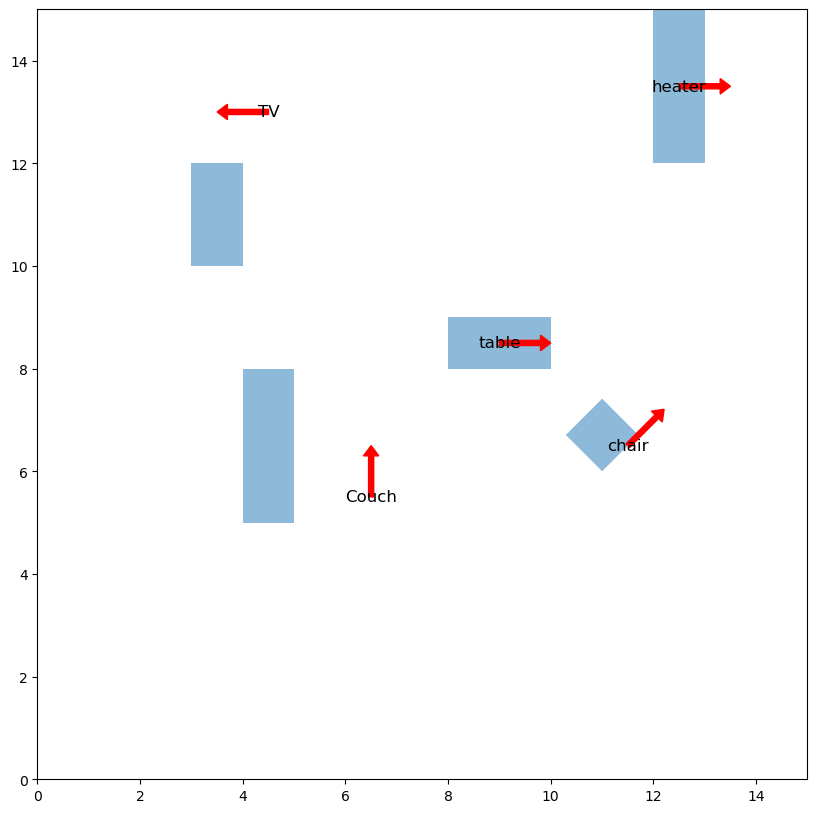

In [223]:
room.draw()


In [224]:
!pip install ipywidgets


In [225]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display


In [226]:
# Pairwise distance widget
pairwise_distance = widgets.FloatSlider(min=1, max=5, step=0.1, value=2, description='Distance:')

# Target angles widget
target_angle_tv = widgets.FloatSlider(min=-180, max=180, step=1, value=0, description='Angle TV:')
target_angle_couch = widgets.FloatSlider(min=-180, max=180, step=1, value=0, description='Angle Couch:')

# Weights widget
weight_distance = widgets.FloatSlider(min=0, max=1, step=0.1, value=0.5, description='Weight Distance:')
weight_angle = widgets.FloatSlider(min=0, max=1, step=0.1, value=0.5, description='Weight Angle:')

# Temperature widget
temperature = widgets.FloatSlider(min=0, max=1000, step=10, value=1000, description='Temperature:')

# Button for random initialization
random_init_button = widgets.Button(description='Random Initialization')

# Function to handle random initialization button
def on_random_init_button_click(_):
    room.random_initialize_furniture()
    room.draw()

random_init_button.on_click(on_random_init_button_click)

# Display control widgets
display(pairwise_distance)
display(target_angle_tv)
display(target_angle_couch)
display(weight_distance)
display(weight_angle)
display(temperature)
display(random_init_button)


FloatSlider(value=2.0, description='Distance:', max=5.0, min=1.0)

FloatSlider(value=0.0, description='Angle TV:', max=180.0, min=-180.0, step=1.0)

FloatSlider(value=0.0, description='Angle Couch:', max=180.0, min=-180.0, step=1.0)

FloatSlider(value=0.5, description='Weight Distance:', max=1.0)

FloatSlider(value=0.5, description='Weight Angle:', max=1.0)

FloatSlider(value=1000.0, description='Temperature:', max=1000.0, step=10.0)

Button(description='Random Initialization', style=ButtonStyle())

In [227]:
def optimize(button):
    # Define initial_temperature, num_iterations, and other necessary parameters
    initial_temperature = 1000
    num_iterations = 1000
    
    # Perform simulated annealing
    room.simulated_annealing(num_iterations, initial_temperature)
    
    # Update the visualization of the room after optimization
    room.draw()



In [228]:
def handle_visualize_checkbox(change):
    if change['type'] == 'change' and change['name'] == 'value':
        room.visualize_intermediate_results = change['new']


In [229]:
import ipywidgets as widgets

optimize_button = widgets.Button(description='Optimize')
optimize_button.on_click(optimize)


In [230]:
visualize_checkbox = widgets.Checkbox(value=False, description='Visualize Intermediate Results')
visualize_checkbox.observe(handle_visualize_checkbox)


In [231]:
display(visualize_checkbox)
display(optimize_button)


Checkbox(value=False, description='Visualize Intermediate Results')

Button(description='Optimize', style=ButtonStyle())

In [232]:
from IPython.display import display
